In [10]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
api = wandb.Api()

# Replace with your entity (username/team) and project name
# entity, project = "s232958-danmarks-tekniske-universitet-dtu", "CLIP_PPint_metaanalysis_weighting"
entity, project = "s232958-danmarks-tekniske-universitet-dtu", "FT_on_meta_weighting"
runs_weighting = api.runs(f"{entity}/{project}")

all_runs_list = [] # Use a list to avoid overwriting CV splits
Keys = ["Train Loss", "Val Loss", "Val AUROC", "Val AUPR", "val_logit_gap", "val_pos_median_logit", "val_neg_median_logit"]

print(f"Fetching history for {len(runs_weighting)} runs...")

for run in tqdm(runs_weighting):
    # Retrieve hyperparameters from run name
    strategy = run.name[7:]
    cv_split = run.name.split("_")[0][-1]
    
    # 2. Optimized Retrieval
    history_scan = run.scan_history(keys=Keys + ["_step"])

    for row in history_scan:
        # Create a single dictionary for this specific epoch/step
        data_point = {
            "strategy": strategy,
            "cv_split": cv_split,
            "epoch": row.get("_step"),
            "train_loss": row.get(Keys[0]),
            "val_loss": row.get(Keys[1]),
            "val_AUROC": row.get(Keys[2]),
            "val_AUPR": row.get(Keys[3]),
            "logit_gap": row.get(Keys[4]),
            "pos_logit": row.get(Keys[5]),
            "neg_logit": row.get(Keys[6])
        }
        all_runs_list.append(data_point)

# entity, project = "s232958-danmarks-tekniske-universitet-dtu", "fintuning_on_metaanalysis_noweighting"
# runs_no_weighting = api.runs(f"{entity}/{project}")

# print(f"Fetching history for {len(runs_no_weighting)} runs...")

# for run in tqdm(runs_no_weighting):
#     # Retrieve hyperparameters from run name
#     strategy = run.name[7:]
#     cv_split = run.name.split("_")[0][-1]
    
#     # 2. Optimized Retrieval
#     history_scan = run.scan_history(keys=Keys + ["_step"])

#     for row in history_scan:
#         # Create a single dictionary for this specific epoch/step
#         data_point = {
#             "strategy": strategy,
#             "cv_split": cv_split,
#             "epoch": row.get("_step"),
#             "train_loss": row.get(Keys[0]),
#             "val_loss": row.get(Keys[1]),
#             "val_AUROC": row.get(Keys[2]),
#             "val_AUPR": row.get(Keys[3]),
#             "logit_gap": row.get(Keys[4]),
#             "pos_logit": row.get(Keys[5]),
#             "neg_logit": row.get(Keys[6])
#         }
#         all_runs_list.append(data_point)

# 3. Convert the list of dicts directly to a DataFrame
Df = pd.DataFrame(all_runs_list)

Fetching history for 25 runs...


100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.22it/s]


In [4]:
# Df_filtered = Df[Df.epoch < 6]
Df_filtered = Df[Df.epoch < 15]
Df_filtered

,strategy,cv_split,epoch,train_loss,val_loss,val_AUROC,val_AUPR,logit_gap,pos_logit,neg_logit
0,class_weight,1,1,0.623180,0.640117,0.660628,0.214114,0.336261,0.156551,-0.179710
1,class_weight,1,2,0.484169,0.618208,0.670679,0.223910,0.464272,0.124268,-0.340004
2,class_weight,1,3,0.388779,0.703934,0.672976,0.234021,0.489798,0.407628,-0.082171
3,class_weight,1,4,0.311640,0.383203,0.673022,0.255779,0.760923,-1.148539,-1.909462
4,class_weight,1,5,0.220014,0.370145,0.643137,0.226908,0.662120,-2.450394,-3.112513
...,...,...,...,...,...,...,...,...,...,...
295,no_weighting,5,8,0.236868,0.352328,0.561772,0.142548,0.151326,-2.699284,-2.850610
296,no_weighting,5,9,0.207296,0.416367,0.527195,0.150577,-0.087102,-4.036895,-3.949793
297,no_weighting,5,10,0.171204,0.478130,0.534577,0.194815,0.071578,-5.040705,-5.112283
298,no_weighting,5,11,0.133626,0.513543,0.520979,0.126424,0.291816,-4.664507,-4.956323


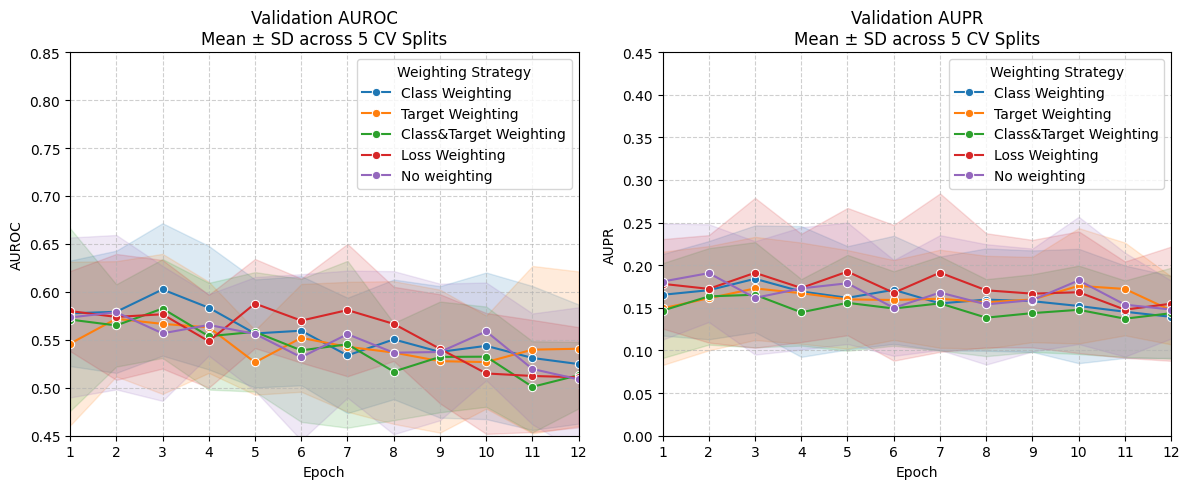

In [40]:
names = {
    "no_weighting" : "No weighting",
    "class_weight" : "Class Weighting", 
    "target_weight" : "Target Weighting",
    "class&target_weight" : "Class&Target Weighting", 
    "loss_weight" : "Loss Weighting", 
}

Df_filtered['Strategy_Label'] = Df_filtered['strategy'].map(names)

plt.figure(figsize=(12, 5))

# Plot AUROC
plt.subplot(1, 2, 1)
sns.lineplot(
    data=Df_filtered, x='epoch', y='val_AUROC', hue='Strategy_Label', 
    marker='o', 
    errorbar='sd', 
    err_kws={'alpha': 0.15}  # Adjust this value to make the SD area lighter or darker
)
plt.title('Validation AUROC\nMean ± SD across 5 CV Splits')
plt.ylim(0.45, 0.85) 
plt.xlim(1, 12)
plt.xticks(np.arange(1, 13))
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Weighting Strategy", loc='upper right', fontsize='medium')

# Plot AUPR
plt.subplot(1, 2, 2)
sns.lineplot(
    data=Df_filtered, x='epoch', y='val_AUPR', hue='Strategy_Label', 
    marker='o', 
    errorbar='sd',
    err_kws={'alpha': 0.15}  # Lower alpha makes overlapping regions easier to distinguish
)
plt.title('Validation AUPR\nMean ± SD across 5 CV Splits')
plt.ylim(0, 0.45)
plt.xlim(1, 12)
plt.xticks(np.arange(1, 13))
plt.xlabel("Epoch")
plt.ylabel("AUPR")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Weighting Strategy", loc='upper right', fontsize='medium')

plt.tight_layout()
plt.show()

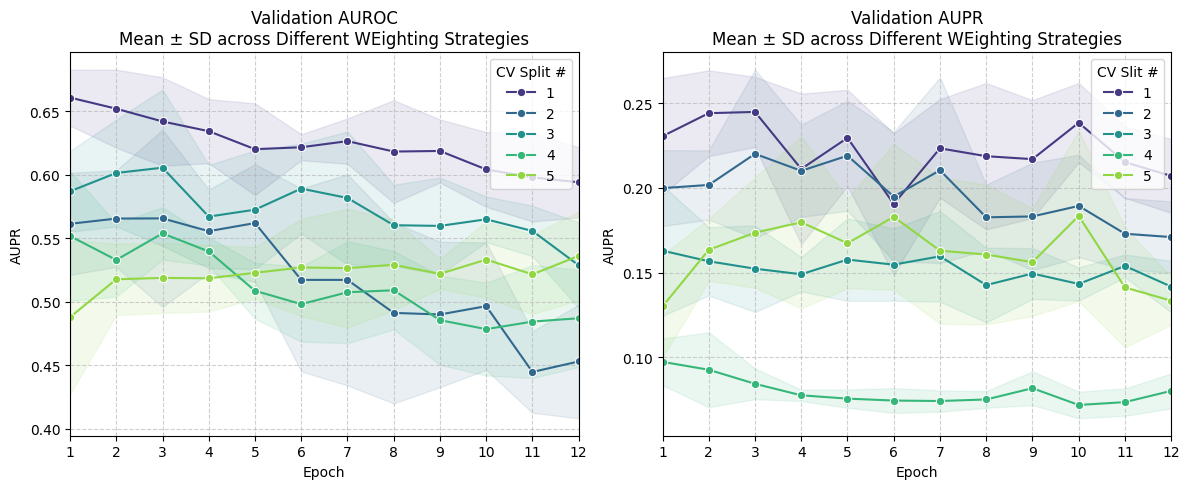

In [41]:
plt.figure(figsize=(12, 5))

# Plot AUROC grouped by Split
plt.subplot(1, 2, 1)
sns.lineplot(
    data=Df_filtered, x='epoch', y='val_AUROC', hue='cv_split', 
    palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1}
)
plt.title('Validation AUROC\nMean ± SD across Different WEighting Strategies')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="CV Split #", loc='upper right', fontsize='medium')
plt.xlim(1, 12)
plt.xticks(np.arange(1, 13))
plt.xlabel("Epoch")
plt.ylabel("AUPR")

# Plot AUPR grouped by Split
plt.subplot(1, 2, 2)
sns.lineplot(
    data=Df_filtered, x='epoch', y='val_AUPR', hue='cv_split', 
    palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1}
)
plt.title('Validation AUPR\nMean ± SD across Different WEighting Strategies')
plt.legend(title="CV Slit #", loc='upper right', fontsize='medium')
plt.xlim(1, 12)
plt.xticks(np.arange(1, 13))
plt.xlabel("Epoch")
plt.ylabel("AUPR")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

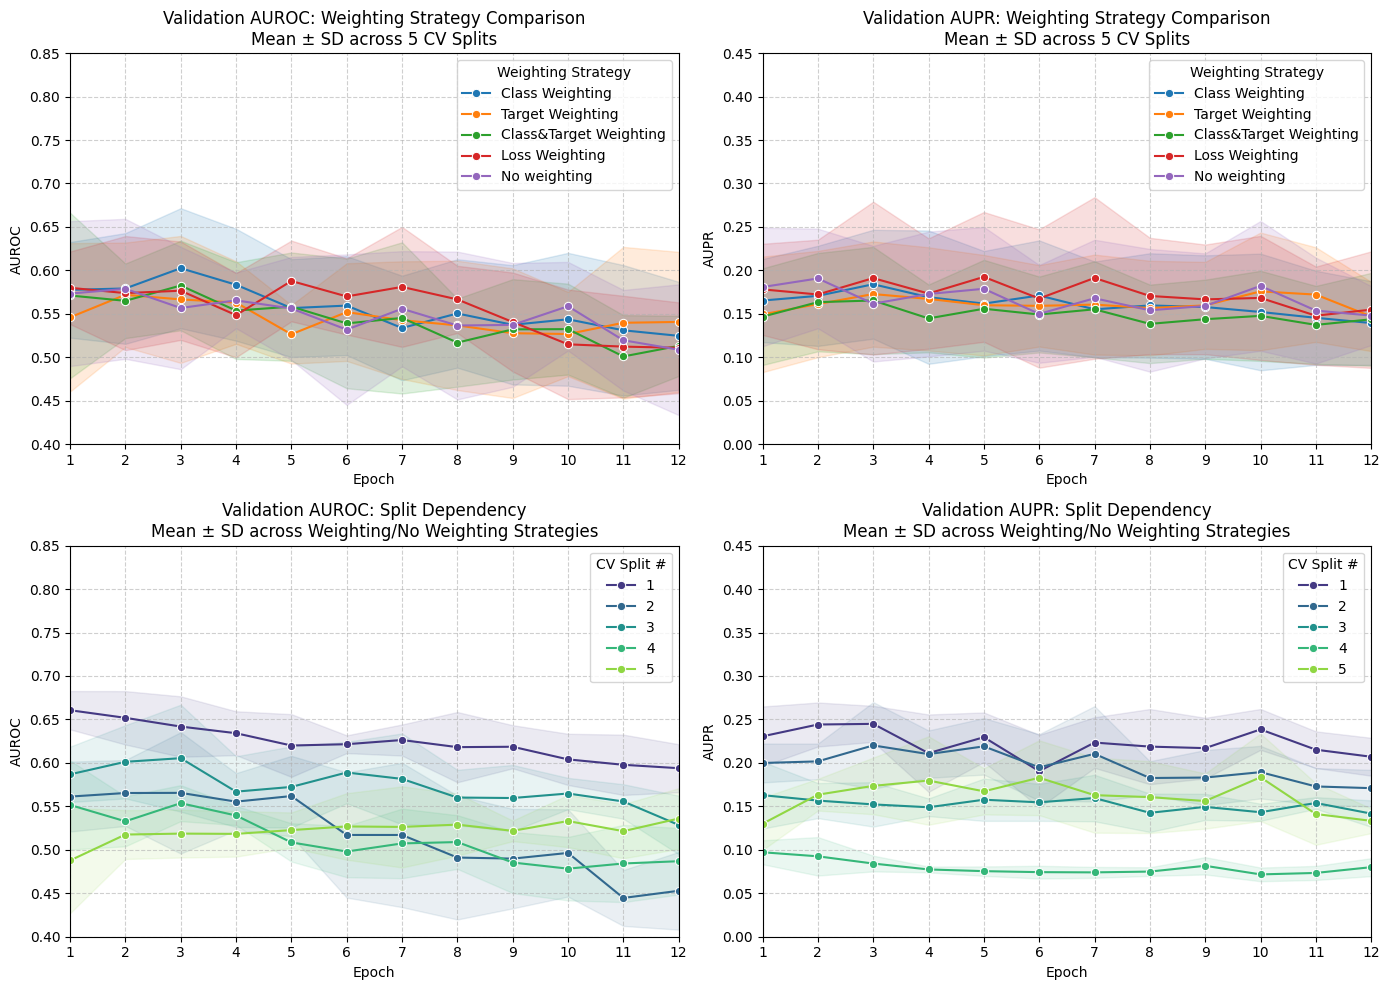

In [42]:
Df_filtered['Strategy_Label'] = Df_filtered['strategy'].map(names)

# Create a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- ROW 1: GROUPED BY STRATEGY (Showing all strategies are similar) ---

# Plot AUROC by Strategy
sns.lineplot(
    ax=axes[0, 0], data=Df_filtered, x='epoch', y='val_AUROC', hue='Strategy_Label', 
    marker='o', errorbar='sd', err_kws={'alpha': 0.15}
)
axes[0, 0].set_title('Validation AUROC: Weighting Strategy Comparison\nMean ± SD across 5 CV Splits')

# Plot AUPR by Strategy
sns.lineplot(
    ax=axes[0, 1], data=Df_filtered, x='epoch', y='val_AUPR', hue='Strategy_Label', 
    marker='o', errorbar='sd', err_kws={'alpha': 0.15}
)
axes[0, 1].set_title('Validation AUPR: Weighting Strategy Comparison\nMean ± SD across 5 CV Splits')

# --- ROW 2: GROUPED BY CV SPLIT (Showing split sensitivity) ---

# Plot AUROC by Split
sns.lineplot(
    ax=axes[1, 0], data=Df_filtered, x='epoch', y='val_AUROC', hue='cv_split', 
    palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1}
)
axes[1, 0].set_title('Validation AUROC: Split Dependency\nMean ± SD across Weighting/No Weighting Strategies')

# Plot AUPR by Split
sns.lineplot(
    ax=axes[1, 1], data=Df_filtered, x='epoch', y='val_AUPR', hue='cv_split', 
    palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1}
)
axes[1, 1].set_title('Validation AUPR: Split Dependency\nMean ± SD across Weighting/No Weighting Strategies')

# --- UNIFIED FORMATTING ---
for i in range(2):
    for j in range(2):
        axes[i, j].set_xlim(1, 12)
        axes[i, j].set_xticks(np.arange(1, 13))
        axes[i, j].set_xlabel("Epoch")
        axes[i, j].grid(True, linestyle='--', alpha=0.6)
        
        # Consistent Y-axis limits for comparison
        if j == 0: # AUROC columns
            axes[i, j].set_ylim(0.40, 0.85)
            axes[i, j].set_ylabel("AUROC")
        else: # AUPR columns
            axes[i, j].set_ylim(0, 0.45)
            axes[i, j].set_ylabel("AUPR")
            
        # Clean up legends
        title = "Weighting Strategy" if i == 0 else "CV Split #"
        axes[i, j].legend(title=title, loc='upper right', fontsize='medium')

plt.tight_layout()
plt.show()

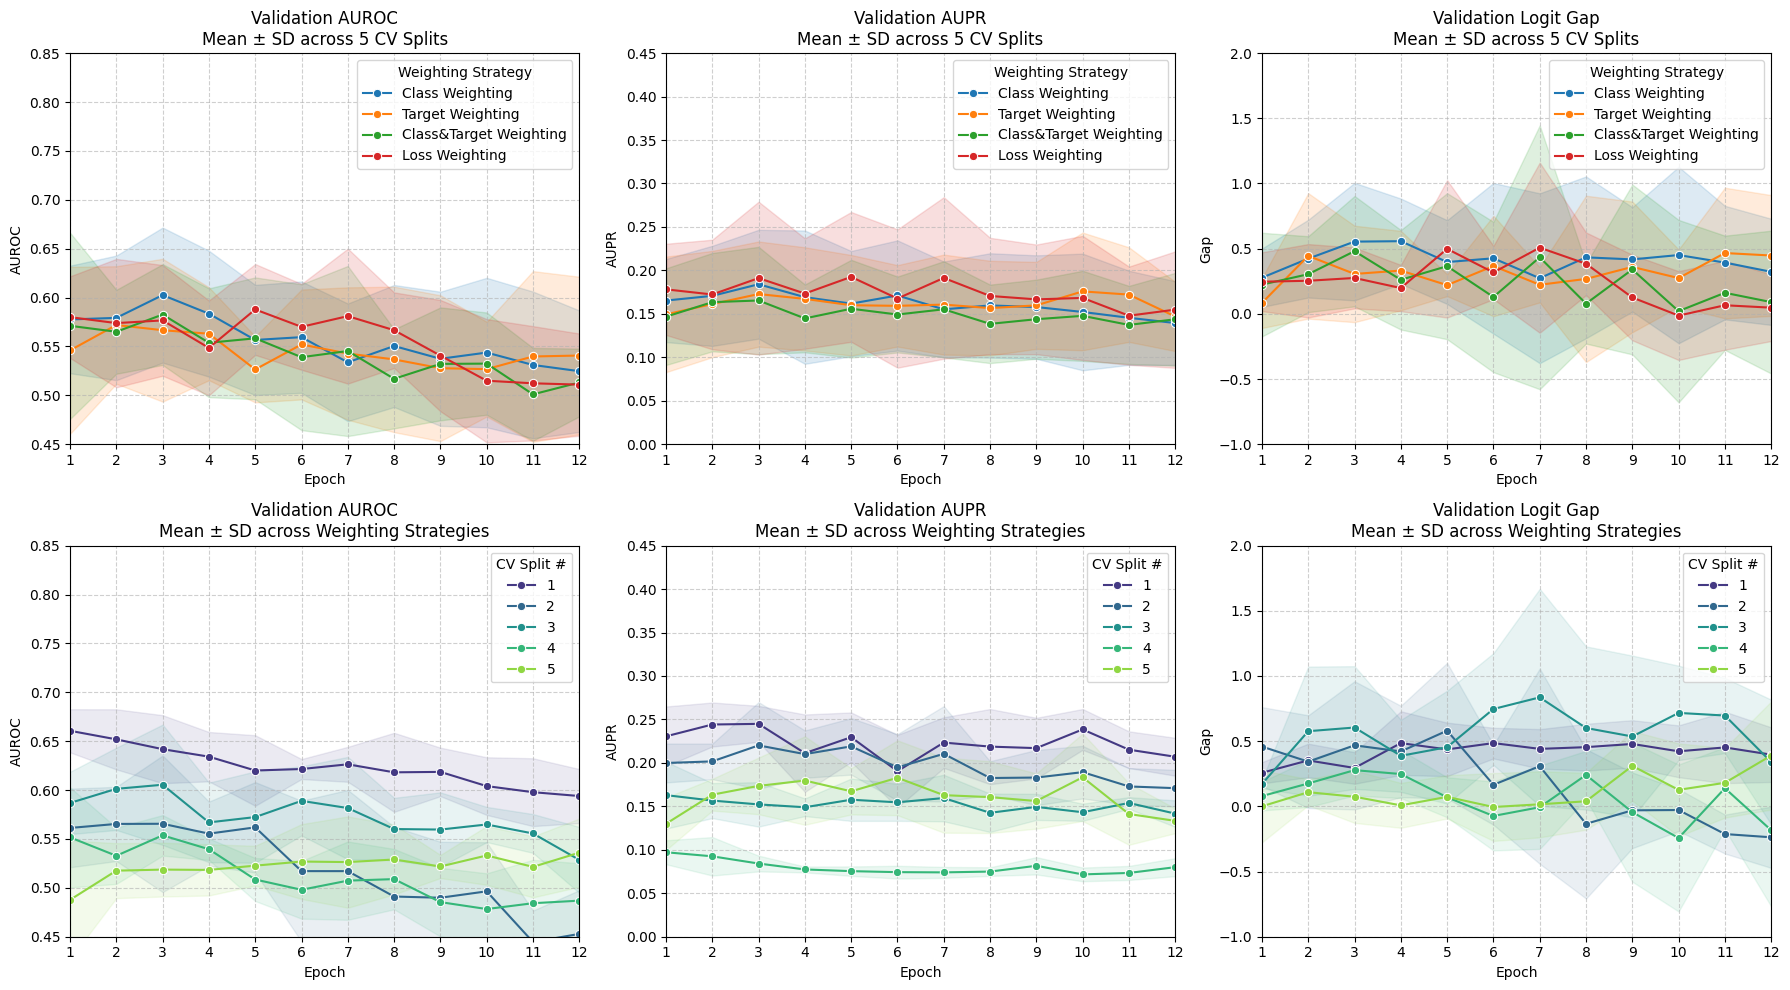

In [29]:
# Mapping Strategy Labels
Df_filtered['Strategy_Label'] = Df_filtered['strategy'].map(names)

# Create a 2x3 grid to accommodate AUROC, AUPR, and Logit Gap for both groupings
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Metrics and their corresponding Y-axis limits
metrics = ['val_AUROC', 'val_AUPR', 'logit_gap']
titles = ['Validation AUROC', 'Validation AUPR', 'Validation Logit Gap']
y_limits = [(0.45, 0.85), (0, 0.45), (-1.0, 2.0)]

for i, metric in enumerate(metrics):
    # --- ROW 1: Grouped by Strategy ---
    sns.lineplot(
        ax=axes[0, i], data=Df_filtered, x='epoch', y=metric, hue='Strategy_Label', 
        marker='o', errorbar='sd', err_kws={'alpha': 0.15}
    )
    axes[0, i].set_title(f'{titles[i]}\nMean ± SD across 5 CV Splits')
    axes[0, i].legend(title="Weighting Strategy", loc='upper right', fontsize='medium')

    # --- ROW 2: Grouped by CV Split ---
    sns.lineplot(
        ax=axes[1, i], data=Df_filtered, x='epoch', y=metric, hue='cv_split', 
        palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1}
    )
    axes[1, i].set_title(f'{titles[i]}\nMean ± SD across Weighting Strategies')
    axes[1, i].legend(title="CV Split #", loc='upper right', fontsize='medium')

# Unified Formatting
for ax_row in axes:
    for j, ax in enumerate(ax_row):
        ax.set_xlim(1, 12)
        ax.set_xticks(np.arange(1, 13))
        ax.set_xlabel("Epoch")
        ax.set_ylabel(titles[j].split()[-1]) # Extracts AUROC, AUPR, or Gap
        ax.set_ylim(y_limits[j])
        ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

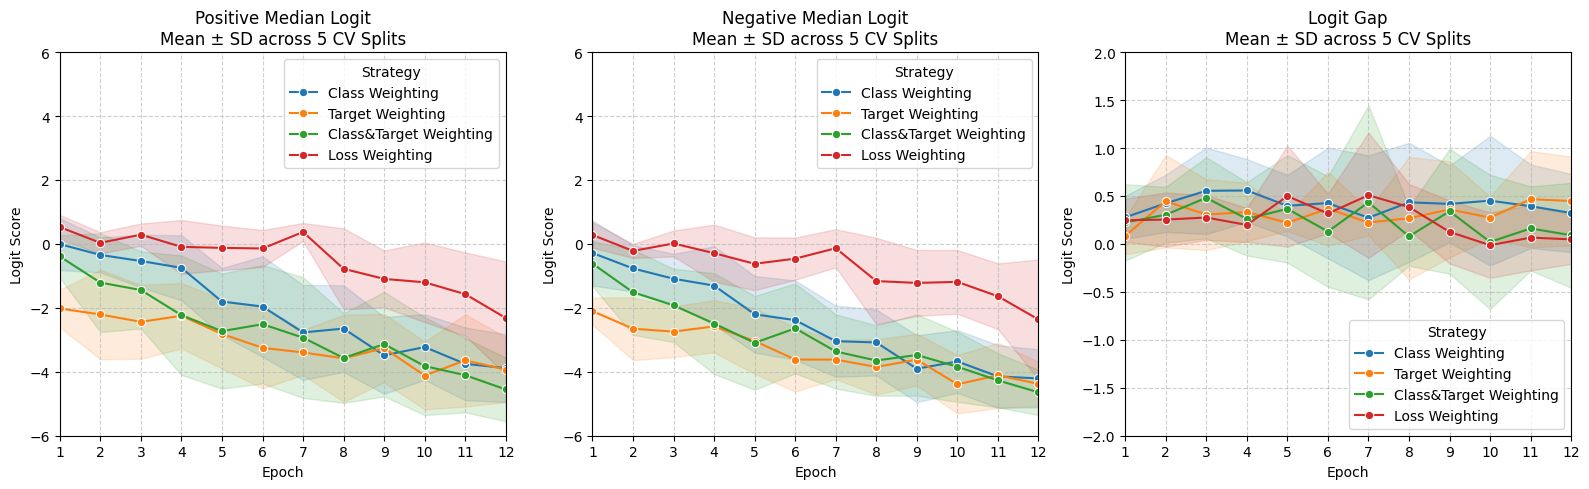

In [39]:
# 1. Define the metrics to plot
# Note: Ensure these column names match your DataFrame from the W&B retrieval
logit_metrics = ['pos_logit', 'neg_logit', 'logit_gap']
logit_titles = ['Positive Median Logit', 'Negative Median Logit', 'Logit Gap']

plt.figure(figsize=(16, 5))

for i, metric in enumerate(logit_metrics):
    plt.subplot(1, 3, i + 1)
    
    # Plotting grouped by Strategy to see if any approach widens the gap
    sns.lineplot(
        data=Df_filtered, x='epoch', y=metric, hue='Strategy_Label', 
        marker='o', errorbar='sd', err_kws={'alpha': 0.15}
    )
    
    plt.title(f'{logit_titles[i]}\nMean ± SD across 5 CV Splits')
    plt.xlim(1, 12)
    plt.xticks(np.arange(1, 13))
    plt.xlabel("Epoch")
    plt.ylabel("Logit Score")
    plt.grid(True, linestyle='--', alpha=0.6)
    if i < 2:
        plt.legend(title="Strategy", loc='upper right', fontsize='medium')
        plt.ylim(-6, 6) # Adjusted limits to capture both pos/neg ranges
    else:
        plt.legend(title="Strategy", loc='lower right', fontsize='medium')
        plt.ylim(-2, 2) # Adjusted limits to capture both pos/neg ranges

plt.tight_layout()
plt.show()